# Parking spot detection

## Imports

In [39]:
import os
import numpy as np #
import cv2 #
import mrcnn.config
import mrcnn.utils
from mrcnn.model import MaskRCNN
from pathlib import Path
from matplotlib import pyplot as plt #
import random


## Configure MaskRCNN

In [3]:
# Configuration that will be used by the Mask-RCNN library
class MaskRCNNConfig(mrcnn.config.Config):
    NAME = "coco_pretrained_model_config"
    IMAGES_PER_GPU = 1
    GPU_COUNT = 1
    NUM_CLASSES = 1 + 80  # COCO dataset has 80 classes + one background class
    DETECTION_MIN_CONFIDENCE = 0.6


# Filter a list of Mask R-CNN detection results to get only the detected cars / trucks
def get_car_boxes(boxes, class_ids):
    car_boxes = []

    for i, box in enumerate(boxes):
        # If the detected object isn't a car / truck, skip it
        if class_ids[i] in [3, 8, 6]:
            car_boxes.append(box)

    return np.array(car_boxes)

## Setup file structure and download COCO weights

In [4]:
# Root directory of the project
ROOT_DIR = Path("..\\")

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "models")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(MODEL_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    mrcnn.utils.download_trained_weights(COCO_MODEL_PATH)

In [5]:
# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, ".\\data\\raw")  #Not using this right now...
#Could use it to train when 'all spots are full' then look for movement

In [6]:
# Video file or camera to process - set this to 0 to use your webcam instead of a video file
VIDEO_SOURCE = os.path.join(IMAGE_DIR,"parkingTest_bestcompress_Trim.mp4")

# Local path to output processed videos
VIDEO_SAVE_DIR = os.path.join(ROOT_DIR, ".\\data\\processed")
VIDEO_SAVE_FILE = os.path.join(VIDEO_SAVE_DIR, "FinalFile.avi")                           

## Create Mask-RCNN model

In [7]:
# Create a Mask-RCNN model in inference mode
model = MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=MaskRCNNConfig())

# Load pre-trained model
model.load_weights(COCO_MODEL_PATH, by_name=True)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


## Function to save openCV frames to avi file

In [8]:
def writeFramesToFile(frame_array, fileName="video.avi", nthFrames=1, fps=15):
    '''writeFramesToFile(frame_array, fileName="video.avi", nthFrames=1, fps=15)
    Writes array of images to a video file of type .avi
    parameters:
      frame_array - python list of frames as pixel values from openCV
      fileName - path to save file
      nthFrames - how many frames to keep, 1 will keep all frames, 2 will remove every other, etc...
      fps - frames per second'''
    assert (len(frame_array) > 0)
    
    #check first frame and find shape
    width = len(frame_array[0][0])
    height = len(frame_array[0])
    size = (width,height)

    #make video writer
    out = cv2.VideoWriter(fileName,cv2.VideoWriter_fourcc(*'DIVX'), fps, size) #name, writer, fps, size

    for i in range(0, len(frame_array), nthFrames):
        out.write(frame_array[i])
    out.release()
    return None

### scratch for testing movie loop

In [9]:
#Make sure the video is being read properly. This is just a check
# Load the video file we want to run detection on
video_capture = cv2.VideoCapture(VIDEO_SOURCE)

# How many frames of video we've seen in a row with a parking space open
free_space_frames = 0
frame_array=[]

# Loop over each frame of video
while video_capture.isOpened():
    success, frame = video_capture.read()
    if not success:
        break

    # Convert the image from BGR color (which OpenCV uses) to RGB color
    rgb_image = frame[:, :, ::-1]
    
    #print number of frames
    font = cv2.FONT_HERSHEY_DUPLEX
    cv2.putText(frame, f"Frame: {len(frame_array)}", (10, 340), font, 0.5, (0, 255, 0), 2, cv2.FILLED)

    # Show the frame of video on the screen
    cv2.imshow('Video', frame)
    
    #Save the frame for a final video output
    frame_array.append(frame)

    # Hit 'q' to quit
    if cv2.waitKey(1000) & 0xFF == ord('q'):
        break

# Clean up everything when finished
video_capture.release()
cv2.destroyAllWindows()
writeFramesToFile(frame_array=frame_array, fileName=VIDEO_SAVE_FILE)
print("done")


done


## Function to detect parking spaces

In [58]:
def detectSpots(video_file, video_save_file='findParkingSpaces.avi', initial_check_frame_cutoff=10):
    '''detectSpots(video_file, initial_check_frame_cutoff=10)
    Returns: np 2D array of bounding boxes of all bounding boxes that are still occupied
    after initial_check_frame_cutoff frames.  These can be considered "parking spaces".
    
    An update might identify any spaces that get occupied at some point and stay occupied 
    for a set length of time, in case some areas start off vacant.'''
    # Load the video file we want to run detection on
    video_capture = cv2.VideoCapture(video_file)

    #Store the annotated frames for output to video/counting how many frames we've seen
    frame_array=[]

    #Will contain bounding boxes of parked cars to identify 'parkable spots'
    parked_car_boxes = []
    parked_car_boxes_updated = []

    # Loop over each frame of video
    while video_capture.isOpened():
        success, frame = video_capture.read()
        if not success:
            print("Processed entire video, exiting")
            break

        # Convert the image from BGR color (which OpenCV uses) to RGB color
        rgb_image = frame[:, :, ::-1]

        #ignore the inbetween frames 0 to x, don't run the model on them and save processing time
        if 0 < len(frame_array) < initial_check_frame_cutoff: 
            print(f"ignore this frame for processing, #{len(frame_array)}")
        else:
            print(f"Processing frame: #{len(frame_array)}")
            # Run the image through the Mask R-CNN model to get results.
            results = model.detect([rgb_image], verbose=0)

            # Mask R-CNN assumes we are running detection on multiple images.
            # We only passed in one image to detect, so only grab the first result.
            r = results[0]

            # The r variable will now have the results of detection:
            # - r['rois'] are the bounding box of each detected object
            # - r['class_ids'] are the class id (type) of each detected object
            # - r['scores'] are the confidence scores for each detection
            # - r['masks'] are the object masks for each detected object (which gives you the object outline)

            if len(frame_array) == 0:
                # This is the first frame of video,
                # Save the location of each car as a parking space box and go to the next frame of video.
                # We check if any of those cars moved in the next 5 frames and assume those that don't are parked
                parked_car_boxes =  get_car_boxes(r['rois'], r['class_ids'])
                parked_car_boxes_init= parked_car_boxes
                print(f'Parking spots 1st frame:', len(parked_car_boxes))

            #If we are past the xth initial frame, already know where parked cars are, then check if any cars moved:                                        
            else:
                # We already know where the parking spaces are. Check if any are currently unoccupied.

                # Get where cars are currently located in the frame
                car_boxes = get_car_boxes(r['rois'], r['class_ids'])

                # See how much those cars overlap with the known parking spaces
                overlaps = mrcnn.utils.compute_overlaps(parked_car_boxes, car_boxes)

                # Loop through each known parking space box
                for row, areas in enumerate(zip(parked_car_boxes, overlaps)):
                    parking_area, overlap_areas = areas
                    # For this parking space, find the max amount it was covered by any
                    # car that was detected in our image (doesn't really matter which car)
                    max_IoU_overlap = np.max(overlap_areas)

                    # Get the top-left and bottom-right coordinates of the parking area
                    y1, x1, y2, x2 = parking_area

                    # Check if the parking space is occupied by seeing if any car overlaps
                    # it by more than x amount using IoU
                    if max_IoU_overlap < 0.20:
                        #In the first few frames, remove this 'spot' and consider it as a moving car instead
                        # Transient event, draw green box
                        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 3)
                    else:
                        #if len(frame_array) == initial_check_frame_cutoff: 
                        #Consider this a parking spot, car is still in it!
                        #Dangerous to mutate array while using it! So make a new one
                        parked_car_boxes_updated.append(list(parking_area))

                        # Parking space is still occupied - draw a red box around it
                        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 1)

                    # Write the IoU measurement inside the box
                    font = cv2.FONT_HERSHEY_DUPLEX
                    cv2.putText(frame, parking_area, (x1 + 6, y2 - 6), font, 0.3, (255, 255, 255))

                parked_car_boxes = np.array(parked_car_boxes_updated)  #only happens once

        #print number of frames
        font = cv2.FONT_HERSHEY_COMPLEX_SMALL
        cv2.putText(frame, f"Frame: {len(frame_array)}", (10, 340), font, 0.5, (0, 255, 0), 2, cv2.FILLED)

        # Show the frame of video on the screen
        cv2.imshow('Video', frame)

        #Append frame to outputvideo
        frame_array.append(frame)

        # Hit 'q' to quit
        if cv2.waitKey(1) & 0xFF == ord('q'):
            print("Quit by user")
            break

        #stop when cutoff reached
        if len(frame_array) > initial_check_frame_cutoff:
            print(f"Finished, processed frames: 0 - {len(frame_array)}")
            break;
        

    # Clean up everything when finished
    video_capture.release()
    cv2.destroyAllWindows()
    writeFramesToFile(frame_array=frame_array, fileName=video_save_file)

    plt.figure(figsize = (64,48))
    plt.imshow(frame[:, :, ::-1], interpolation='nearest')
    plt.tight_layout() #Convert to RBG
    plt.title('Identified Spots')
    plt.show()
    return parked_car_boxes

## Function to find vacant spots

In [75]:
def countSpots(video_source, parked_car_boxes, video_save_file="annotatedVideo.avi",
               framesToProcess=True, freeSpaceFrameCutOff=5, showVideo = True):
    '''Counts how many spots are vacant at the end of the video 
    saves a video showing spots being vacant
    returns: count of spots in final frame that are vacant
    inputs: video_source: file path
            parked_car_boxes: bounding boxes of parking spaces
            video_save_file: default "annotatedVideo.avi", video with annotations
            framesToProcess: default to all frames.  Enter an int to process only part of the file. Good for saving time
            freeSpaceFrameCutOff: default 2, number of frames a spot must be empty before appearing as such, helps with jitter'''
    # Load the video file we want to run detection on
    video_capture = cv2.VideoCapture(video_source)

    #Store the annotated frames for output to video
    frame_array=[]
    
    #Dictionary of parking space index and how many frames it's been 'free'
    carBoxes_OpenFrames = {i: 0 for i in range(len(parked_car_boxes))}

    # Loop over each frame of video
    while video_capture.isOpened():
        success, frame = video_capture.read()
        if not success:
            break

        # Convert the image from BGR color (which OpenCV uses) to RGB color
        rgb_image = frame[:, :, ::-1]

        print(f"Processing frame: #{len(frame_array)}")
        # Run the image through the Mask R-CNN model to get results.
        results = model.detect([rgb_image], verbose=0)

        # Mask R-CNN assumes we are running detection on multiple images.
        # We only passed in one image to detect, so only grab the first result.
        r = results[0]

        # The r variable will now have the results of detection:
        # - r['rois'] are the bounding box of each detected object
        # - r['class_ids'] are the class id (type) of each detected object
        # - r['scores'] are the confidence scores for each detection
        # - r['masks'] are the object masks for each detected object (which gives you the object outline)

        # We already know where the parking spaces are. Check if any are currently unoccupied.

        # Get where cars are currently located in the frame
        car_boxes = get_car_boxes(r['rois'], r['class_ids'])

        # See how much those cars overlap with the known parking spaces
        overlaps = mrcnn.utils.compute_overlaps(parked_car_boxes, car_boxes)

        # Assume no spaces are free until we find one that is free
        free_spaces = 0

        # Loop through each known parking space box
        for row, areas in enumerate(zip(parked_car_boxes, overlaps)):
            parking_area, overlap_areas = areas
            # For this parking space, find the max amount it was covered by any
            # car that was detected in our image (doesn't really matter which car)
            max_IoU_overlap = np.max(overlap_areas)

            # Get the top-left and bottom-right coordinates of the parking area
            y1, x1, y2, x2 = parking_area

            # Check if the parking space is empty by seeing if any car overlaps
            # it by more than x amount using IoU
            if max_IoU_overlap < 0.20:    
                #If the spot has appeared open long enough, count it as free!
                # This is so we don't alert based on one frame of a spot being open/closed.
                # This helps prevent the script triggered on one bad detection.
                if carBoxes_OpenFrames[row] > freeSpaceFrameCutOff:
                    # Parking space not occupied! Draw a green box around it
                    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 3)
                    
                    #Count this as occupied, and don't let it be immediately changed
                    carBoxes_OpenFrames[row] = freeSpaceFrameCutOff * 2
                else:
                    # Parking space is still occupied - draw a red box around it
                    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 1)
                    
                    # Tag this spot as being open for +1 frame
                    carBoxes_OpenFrames[row] += 1

            else:
                #else, spot appears occupied this frame 
                #If it's been occupied for more than the frame cutoff:
                if carBoxes_OpenFrames[row] <= freeSpaceFrameCutOff:
                    # Parking space is occupied - draw a red box around it
                    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 1)
                    #Set the frame counter to 0, it's full, don't let it change immediately
                    carBoxes_OpenFrames[row] = 0 
                else:
                     #Start counting frames this spot is full,
                    # So script isn't triggered from someone driving by
                    carBoxes_OpenFrames[row] -= 1

                    # Parking space still 'free'. Draw a green box around it
                    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 3)
                
            # Write the IoU measurement inside the box
            font = cv2.FONT_HERSHEY_DUPLEX
            cv2.putText(frame, f"{max_IoU_overlap:0.2}", (x1 + 6, y2 - 6), font, 0.3, (255, 255, 255))

      
        # If a space has been free for several frames, let's count it as free
        #  loop through all 'free' frames and sum the result
        free_spaces = sum([int(i) > freeSpaceFrameCutOff for i in carBoxes_OpenFrames.values()])
            
        # Write how many free spots there are at the top of the screen
        font = cv2.FONT_HERSHEY_DUPLEX
        cv2.putText(frame, f"Free Spaces: {free_spaces}", (30, 30), font, 1.0, (0, 255, 0), 2, cv2.FILLED)

        print(f'Free Spaces: {free_spaces}')
        #print number of frames
        font = cv2.FONT_HERSHEY_COMPLEX_SMALL
        cv2.putText(frame, f"Frame: {len(frame_array)}", (10, 340), font, 0.5, (255, 255, 255))

        # Show the video in a new window
        if showVideo:
            cv2.imshow('Video', frame)

        #Append frame to outputvideo
        frame_array.append(frame)

        # Hit 'q' to quit showing video
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        
        if (framesToProcess != True and len(frame_array) > framesToProcess):
            print(f"Stopped processing at frame {len(frame_array)} as requested by framesToProcess parameter")
            break

    # Clean up everything when finished
    video_capture.release()  #free the video
    if showVideo: 
        cv2.destroyAllWindows()  #Close the video player
    writeFramesToFile(frame_array=frame_array, fileName=video_save_file) #save the file
    print("done")
    return free_spaces

## Code to find spots on given movie

Processing frame: #0
Parking spots 1st frame: 23
ignore this frame for processing, #1
ignore this frame for processing, #2
ignore this frame for processing, #3
ignore this frame for processing, #4
ignore this frame for processing, #5
ignore this frame for processing, #6
ignore this frame for processing, #7
ignore this frame for processing, #8
ignore this frame for processing, #9
ignore this frame for processing, #10
ignore this frame for processing, #11
Processing frame: #12
Finished, processed frames: 0 - 13


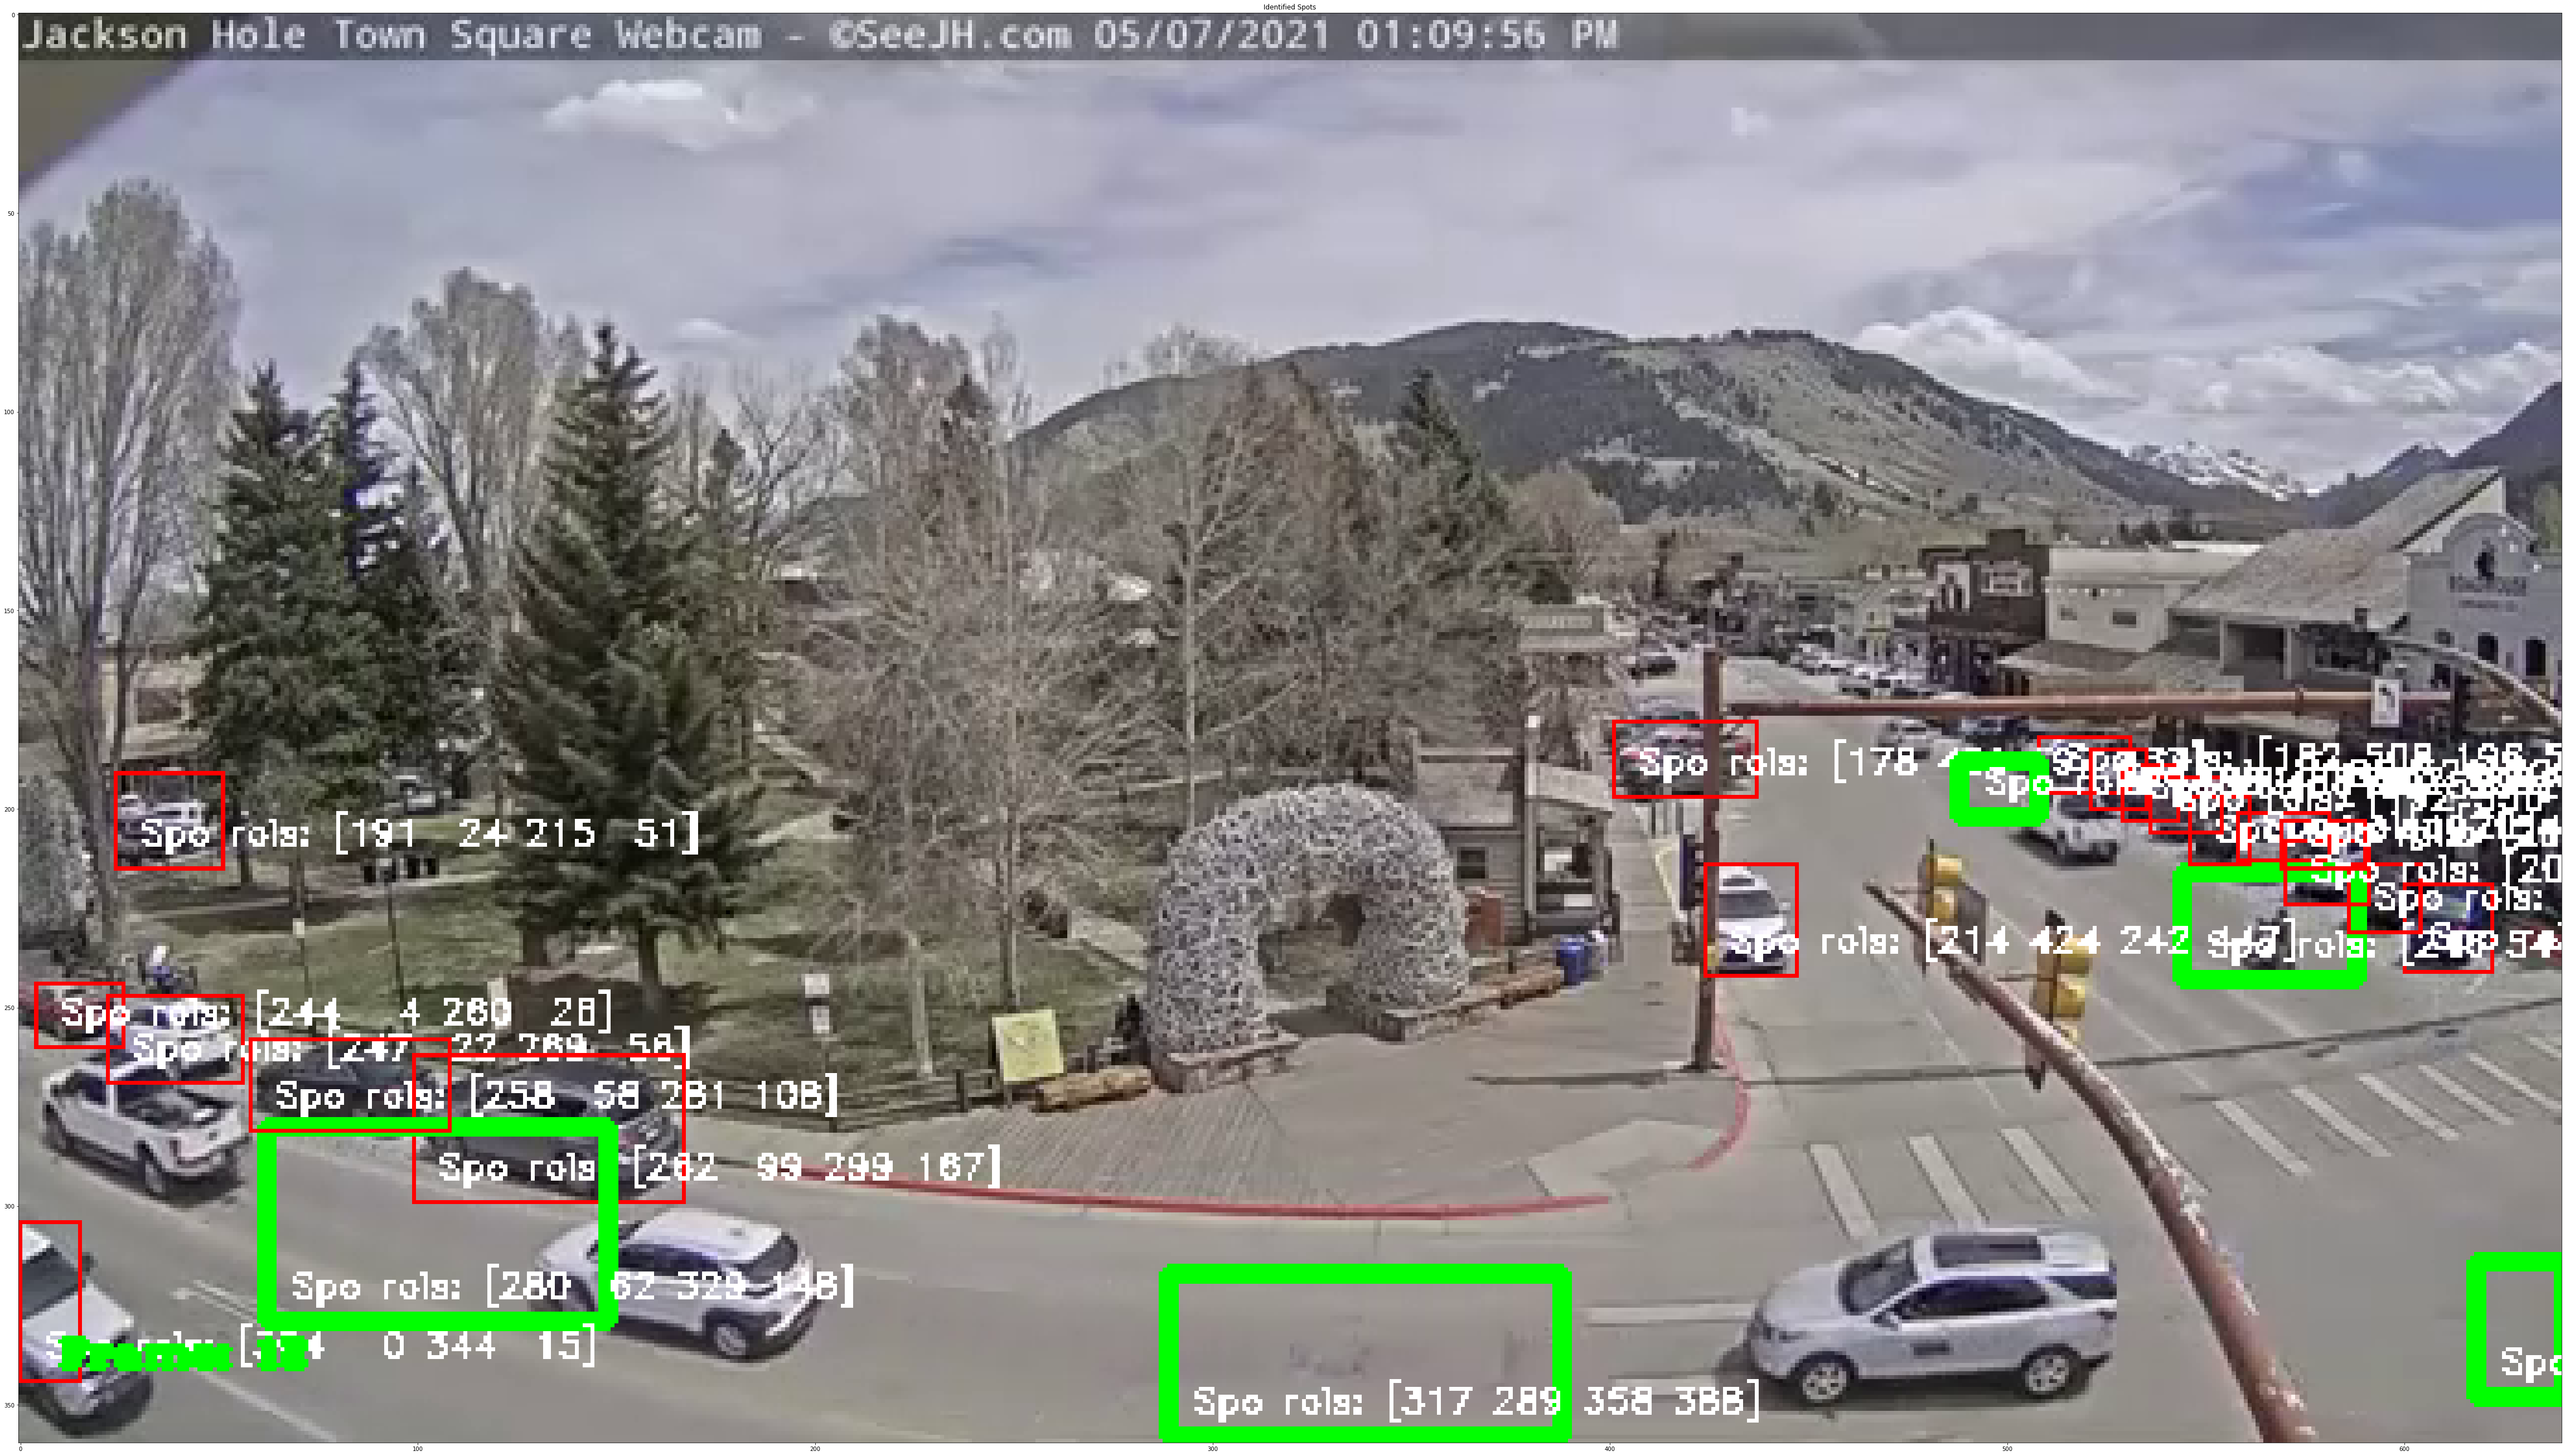

In [31]:
parked_car_boxes = detectSpots(VIDEO_SOURCE, os.path.join(VIDEO_SAVE_DIR, "findSpots.avi"), 12)

In [32]:
#One of those 'spots' is actually a car, I'm going to remove it manually
badSpot = np.where(parked_car_boxes == [304,   0, 344,  15])
parked_car_boxes = np.delete(parked_car_boxes, badSpot[0][0], axis=0)

#Save edited boxes to file for future use
np.savetxt(os.path.join(ROOT_DIR,'spot_boxes.csv'), parked_car_boxes, delimiter=',')

In [76]:
countSpots(video_source = VIDEO_SOURCE, parked_car_boxes=parked_car_boxes, video_save_file=VIDEO_SAVE_FILE,
          freeSpaceFrameCutOff=10)

Processing frame: #0
Free Spaces: 0
Processing frame: #1
Free Spaces: 0
Processing frame: #2
Free Spaces: 0
Processing frame: #3
Free Spaces: 0
Processing frame: #4
Free Spaces: 0
Processing frame: #5
Free Spaces: 0
Processing frame: #6
Free Spaces: 0
Processing frame: #7
Free Spaces: 0
Processing frame: #8
Free Spaces: 0
Processing frame: #9
Free Spaces: 0
Processing frame: #10
Free Spaces: 0
Processing frame: #11
Free Spaces: 0
Processing frame: #12
Free Spaces: 0
Processing frame: #13
Free Spaces: 0
Processing frame: #14
Free Spaces: 0
Processing frame: #15
Free Spaces: 0
Processing frame: #16
Free Spaces: 0
Processing frame: #17
Free Spaces: 0
Processing frame: #18
Free Spaces: 0
Processing frame: #19
Free Spaces: 0
Processing frame: #20
Free Spaces: 0
Processing frame: #21
Free Spaces: 0
Processing frame: #22
Free Spaces: 0
Processing frame: #23
Free Spaces: 0
Processing frame: #24
Free Spaces: 0
Processing frame: #25
Free Spaces: 0
Processing frame: #26
Free Spaces: 0
Processing 

Free Spaces: 2
Processing frame: #219
Free Spaces: 2
Processing frame: #220
Free Spaces: 2
Processing frame: #221
Free Spaces: 2
Processing frame: #222
Free Spaces: 2
Processing frame: #223
Free Spaces: 2
Processing frame: #224
Free Spaces: 2
Processing frame: #225
Free Spaces: 2
Processing frame: #226
Free Spaces: 2
Processing frame: #227
Free Spaces: 2
Processing frame: #228
Free Spaces: 2
Processing frame: #229
Free Spaces: 2
Processing frame: #230
Free Spaces: 2
Processing frame: #231
Free Spaces: 2
Processing frame: #232
Free Spaces: 2
Processing frame: #233
Free Spaces: 2
Processing frame: #234
Free Spaces: 2
Processing frame: #235
Free Spaces: 2
Processing frame: #236
Free Spaces: 2
Processing frame: #237
Free Spaces: 2
Processing frame: #238
Free Spaces: 2
Processing frame: #239
Free Spaces: 2
Processing frame: #240
Free Spaces: 2
Processing frame: #241
Free Spaces: 2
Processing frame: #242
Free Spaces: 2
Processing frame: #243
Free Spaces: 2
Processing frame: #244
Free Spaces:

3

In [72]:
type(carBoxes_OpenFrames)

dict